In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import skimage.io as io
from skimage import util

from glob import glob
import trackpy

import ast
from ipywidgets import interact, widgets


# import code from the src
### import code from src folder
import sys
sys.path.append('../src/')
import chow_test_v

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


from functools import reduce
import traj_descriptors as td

In [2]:
file_list=glob("../data/*_Dark_prepared.tif")
images_dict={}
for file_name in file_list:
    images_prepared=io.imread(file_name)
    file_prefix=os.path.split(file_name)[1].split('.')[0].split("_prepared")[0]
    
    binary_file=file_name.split(".tif")[0]+'_segmented'+'.tif'
    images_binary=io.imread(binary_file)
    tracks=pd.read_csv("../data/tracks_overlay_id_"+file_prefix+'.csv')
    tracks_big=pd.read_csv("../data/tracks_overlay_id_"+file_prefix+'_big.csv')
    img_dict={"img":images_prepared,"binary":images_binary,"tracks":tracks,"tracks_big":tracks_big}
    
    images_dict[file_prefix]=img_dict

## Calculate TrajMetrics
### trajectory global descriptors
* max_distance_origin(traj)
* total_displacement(traj)
* end_to_end_displacement
* persistence(traj)
* MSD(traj)

### trajectory local descriptors
* global_angle(traj)
* relative_angle(traj)
* displacement

In [3]:
"""
Created on Mon Oct 28 09:58:23 2019

@author: pichugina
"""
from sklearn.linear_model import LinearRegression


def traj_translational_exponent(Traj):
    """
    calculate translational exponent and diffusion coefficient
    input: coordinats of the trajectory, 
           dx physical units to recalculate px to mkm 
    output: translational exponent,Diffusion mkm^2/s
    """
    #pixel size mkm
    dx=1.42
    #time frame s
    dt=6
    
    Traj=Traj.sort_values('frame')
    X=Traj['x'].values
    Y=Traj['y'].values
    
    # length of trajectory
    n_lag=5
    tlen = Traj.shape[0]
    delt=np.arange(1,n_lag+1)
    MSD = np.zeros(len(delt))

    for td in delt:
        index1=range(td,tlen)
        index2=range(0,tlen-td)
        dv = (X[index1]-X[index2])**2 + (Y[index1]-Y[index2])**2;
        dv = dx*dx*dv;   # convert to physical units
        MSD[td-1] = np.sum(dv)/len(dv);

    delt=delt*dt
    
    Log_delt=np.log(delt).reshape((-1, 1))
  
    if ((MSD>0).all()):
        Log_MSD=np.log(MSD)
        reg=LinearRegression().fit(Log_delt,Log_MSD)
        r_sq = reg.score(Log_delt,Log_MSD)
        Intersept=reg.intercept_
        Slope=reg.coef_[0]
        D=0.25*np.exp(Intersept)
        results=pd.Series([r_sq,Slope,D],index=['r_sq','Slope','D_mkm2/s'])
        y_pred = reg.predict(Log_delt)
    else:
        results=pd.Series([np.nan,np.nan,np.nan],index=['r_sq','Slope','D_mkm2/s'])
    
    return results

In [49]:
def calculate_metrix(file_prefix):
    Group_Traj=images_dict[file_prefix]["tracks"].groupby('particle')
    df1=Group_Traj.apply(td.total_displacement).reset_index(name='TOTAL_DIST')
    df2=Group_Traj.apply(td.end_to_end_displacement).reset_index(name='END_TO_END')
    df3=Group_Traj.apply(td.persistence).reset_index(name='PERSISTENCE')
    df4=Group_Traj.apply(td.MSD).reset_index(name='MSD')
    df5=Group_Traj.apply(td.max_distance_origin).reset_index(name='MAX_DIST_ORIG')
    df6=Group_Traj.apply(len).reset_index(name='TRAJ_LEN')
    df7=Group_Traj['area'].apply(np.median).reset_index(name='MEDIAN_AREA')
    df8=Group_Traj['area'].apply(np.max).reset_index(name='MAX_AREA')
    df9=Group_Traj['major_axis_length'].apply(np.median).reset_index(name='MEDIAN_MAJOR_AXIS')
    Translational_exponent=Group_Traj.apply(traj_translational_exponent)
    Global_angle=Group_Traj.apply(td.global_angle).reset_index(name='GLOBAL_ANGLE')
    Relative_angle=Group_Traj.apply(td.relative_angle).reset_index(name='RELATIVE_ANGLE')

    df=[df1,df2,df3,df4,df5,df6,df8,df9,Translational_exponent,Global_angle,Relative_angle]
    TrajDescriptors = reduce(lambda  left,right: pd.merge(left,right,on=['particle'],how='outer'), df)
    TrajDescriptors=TrajDescriptors.set_index('particle')
    
    TrajDescriptors['file_prefix']=file_prefix
    
    return TrajDescriptors
    
    

In [50]:
TrajDescriptors_all=pd.DataFrame()

for file_prefix in images_dict.keys():
    print(file_prefix)
    TrajDescriptors=calculate_metrix(file_prefix)
    TrajDescriptors_all=pd.concat([TrajDescriptors_all,TrajDescriptors])

43125_Dark
43121_Dark
43122_Dark
43123_Dark


In [51]:
TrajDescriptors_all

TOTAL_DIST  END_TO_END  PERSISTENCE        MSD  MAX_DIST_ORIG  \
particle                                                                  
1          50.469137    1.837082     0.036400   0.495373       2.200354   
3          77.669425   64.829430     0.834684  14.593239      64.829430   
4          51.523046    5.352493     0.103885   0.523917       5.674392   
5          50.199308    2.553196     0.050861   0.779463       4.971771   
6         171.681301    1.751905     0.010204   1.794613      19.067504   
...              ...         ...          ...        ...            ...   
2272       61.229231   28.836197     0.470955  10.770302      35.498680   
2286        3.028489    0.242956     0.080224   0.528854       0.528231   
2296       68.245484   18.830328     0.275920  15.149347      18.830328   
2298       46.272945   12.875995     0.278262  12.176280      14.888787   
2304       55.008612   18.966401     0.344790  14.301868      18.966401   

          TRAJ_LEN  MAX_AREA  MEDIAN_MAJOR_AXIS      r_sq     Slope  \
particle                                                              
1              120       513          33.041927  0.376356  0.083820   
3                7        49           5.327693  0.999735  1.822531   
4              120      3961          96.326816  0.945939  0.689250   
5              120       476          25.297571  0.751728  0.135225   
6              120      1170          46.263254  0.999474  1.403667   
...            ...       ...                ...       ...       ...   
2272             7        21           4.822171  0.989405  1.341730   
2286             7        25           4.167620  0.064318 -0.166437   
2296             6        63           9.062336  0.529349  0.407124   
2298             5        20           5.203549       NaN       NaN   
2304             5        49           7.702121       NaN       NaN   

           D_mkm2/s                                       GLOBAL_ANGLE  \
particle                                                                 
1          0.101188  [-60.380080565034824, 126.10681715706204, -64....   
3          4.027975  [-55.969757966799165, -125.0428722780915, -147...   
4          0.036574  [-137.34735604862502, -137.0346364751007, 53.6...   
5          0.251144  [-160.17439843128173, 122.81405758292263, 49.8...   
6          0.128802  [-63.05462258274292, -54.375318034073565, -37....   
...             ...                                                ...   
2272       5.035522  [173.81138403675837, 45.81150068371155, 163.43...   
2286       0.192093  [-40.23635830927922, 108.43494882292447, -96.3...   
2296      60.775526  [-114.4730042571054, 104.63046203682316, -31.5...   
2298            NaN  [-97.71983708839431, 49.71882101185322, 126.90...   
2304            NaN  [-113.8086090211252, 41.34973562795057, -148.3...   

                                             RELATIVE_ANGLE file_prefix  
particle                                                                 
1         [173.5131022779032, 169.06823678379547, 171.05...  43125_Dark  
3         [69.0731143112923, 22.724288130915593, 29.3359...  43125_Dark  
4         [0.3127195735240874, 169.36033567515696, 82.81...  43125_Dark  
5         [77.01154398579564, 72.98023201973955, 70.4808...  43125_Dark  
6         [8.67930454866936, 17.237457386759626, 15.2983...  43125_Dark  
...                                                     ...         ...  
2272      [127.99988335304685, 117.62242341777853, 10.22...  43123_Dark  
2286      [148.67130713220368, 155.22485943117243, 38.65...  43123_Dark  
2296      [140.89653370607144, 136.16341706782913, 77.72...  43123_Dark  
2298      [147.43865810024755, 77.18439781634193, 96.709...  43123_Dark  
2304      [155.15834464907573, 170.27503153306682, 112.7...  43123_Dark  

[1378 rows x 14 columns]

## Filter small objects

In [52]:
TrajDescriptors_all=TrajDescriptors_all[(TrajDescriptors_all['TRAJ_LEN']>15) & (TrajDescriptors_all['MAX_AREA']<500)]
TrajDescriptors_all['RATIO']=TrajDescriptors_all["MAX_DIST_ORIG"]/TrajDescriptors_all['MEDIAN_MAJOR_AXIS']

In [53]:
TrajDescriptors_all[TrajDescriptors_all['RATIO']>3].head(20)

TOTAL_DIST  END_TO_END  PERSISTENCE        MSD  MAX_DIST_ORIG  \
particle                                                                   
26        1114.050852  674.252385     0.605226  17.511448     674.252385   
44        1491.676054  807.832863     0.541561  13.989669     896.941005   
50         606.043111  121.530367     0.200531  11.643484     160.141294   
56          38.991016   25.518633     0.654475   0.948248      25.518633   
73          47.108348   25.552029     0.542410   3.550646      25.552029   
89         542.334452  440.560194     0.812340  18.337697     440.560194   
90         281.929900  138.775512     0.492234  16.740914     138.775512   
95         137.341082   76.535790     0.557268  11.320048      76.535790   
110        366.830476  109.000930     0.297143  13.268366     111.217350   
119        428.121330  216.029624     0.504599  18.808045     216.029624   
131        515.907180  362.908128     0.703437  13.464035     362.908128   
137        304.893367  199.647491     0.654811  15.383503     199.647491   
159         35.214986   17.078795     0.484987   0.842785      17.078795   
163        169.843923  131.166305     0.772276  11.712602     131.166305   
169        930.293293  493.128786     0.530079  12.915072     493.128786   
177        496.914580  345.339139     0.694967  14.146212     345.339139   
182        200.984092  132.994038     0.661714  14.964084     138.334408   
184       1259.713662  728.765789     0.578517  19.914625     728.765789   
185        273.478632  136.062970     0.497527  10.275783     146.999577   
186        550.806931  342.001186     0.620909  11.823065     342.001186   

          TRAJ_LEN  MAX_AREA  MEDIAN_MAJOR_AXIS      r_sq     Slope  \
particle                                                              
26              71       257          18.327161  0.999734  1.515411   
44             120       225          17.611340  0.999942  1.663152   
50              87       273          26.900101  0.977405  1.345646   
56              47        18           3.464102  0.998010  1.471078   
73              16        47           5.611604  0.959156  1.033300   
89              35       297          20.470726  0.999722  1.844070   
90              19        74          12.245966  0.992579  1.556678   
95              16        85           9.775087  0.972773  0.974791   
110             32        64           8.633753  0.995055  0.940562   
119             26       262          15.627078  0.992932  1.207318   
131             46       447          29.284810  0.999774  1.692823   
137             23       116          11.449192  0.992899  1.438659   
159             52        38           4.332399  0.996185  1.161947   
163             17        49           7.594829  0.997836  1.410473   
169             82        82           8.529665  0.998710  1.415202   
177             40        78           8.990117  0.999634  1.575185   
182             17       159          17.889295  0.969075  1.367136   
184             69        75           8.861245  0.998857  1.523803   
185             30       144          19.122947  0.998971  1.371446   
186             51       156          17.007904  0.994982  1.522750   

           D_mkm2/s                                       GLOBAL_ANGLE  \
particle                                                                 
26        10.384074  [-92.94762210673703, -104.28312662405305, -79....   
44         5.024261  [-105.5047247100715, -110.9048351068132, -42.5...   
50         6.870855  [-17.622018830994413, -21.95951897131652, -46....   
56         0.031299  [-93.6913859864085, -162.22867917708902, 178.3...   
73         1.124625  [64.35542905023811, 36.12880738551519, -136.54...   
89         6.330701  [-102.19973562850555, -112.40806288069541, -13...   
90         9.273419  [109.627171761097, 32.7957670140663, 36.398137...   
95        10.440390  [-113.06741086423942, -118.11896748951398, 103...   
110       16.494576  [-119.69040261

(0.0, 10.0)

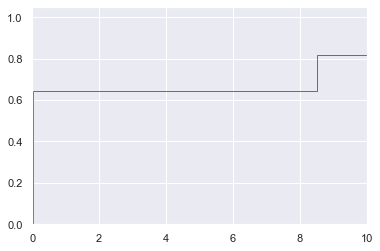

In [54]:
plt.hist(TrajDescriptors_all["RATIO"],density=True, histtype='step',cumulative=True)
plt.xlim([0,10])

## Percent fixed vs moving for each experiments

In [55]:
TrajDescriptors_all["type"]="fixed"
TrajDescriptors_all["type"][TrajDescriptors_all['RATIO']>3]="moving"

TrajDescriptors_all["type"].value_counts()

moving    253
fixed     218
Name: type, dtype: int64

<Figure size 720x720 with 0 Axes>

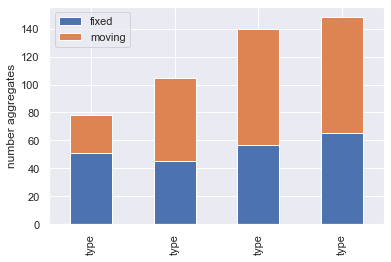

In [56]:
Df=[]
for id,group in TrajDescriptors_all.groupby('file_prefix'):
    df=group["type"].value_counts()
    df['file_prefix']=id
    df['total']=df["fixed"]+df["moving"]
    Df.append(df)
Df=pd.DataFrame(Df)    
    
sns.set()
plt.figure(figsize=(10,10))
Df[['fixed','moving']].plot(kind='bar', stacked=True)
#plt.xlabel("experiment 2021-02-19");
plt.ylabel("number aggregates");

plt.savefig("../results/classes_summary_small_objects.png",bbox_inches="tight")

In [32]:
TrajDescriptors_all["MAX_DIST_ORIG_NORM"]=TrajDescriptors_all["MAX_DIST_ORIG"]/TrajDescriptors_all["TRAJ_LEN"]

<AxesSubplot:xlabel='file_prefix', ylabel='MAX_DIST_ORIG_NORM'>

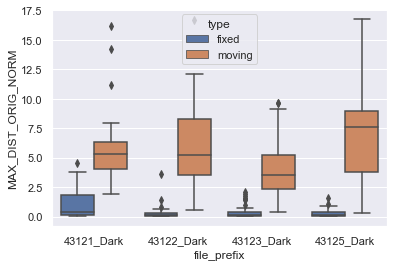

In [33]:
sns.boxplot(data=TrajDescriptors_all,x="file_prefix",order=["43121_Dark","43122_Dark","43123_Dark","43125_Dark"],y="MAX_DIST_ORIG_NORM",hue="type")

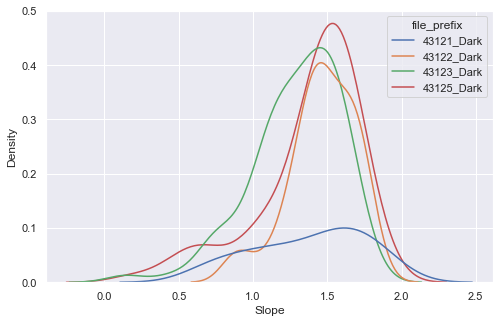

In [34]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,5))
sns.kdeplot(x="Slope",hue="file_prefix",hue_order=["43121_Dark","43122_Dark","43123_Dark","43125_Dark"],data=TrajDescriptors_all[TrajDescriptors_all["type"]=="moving"],ax=ax)
plt.savefig("../results/Slopes_small_objects.png",bbox_inches="tight")

## Global Angle

In [43]:
Moving=TrajDescriptors_all[TrajDescriptors_all["type"]=="moving"]
df_Global_Angle_all=pd.DataFrame()

for file_id, df in Moving.groupby("file_prefix"):
    Global_angle=np.hstack(df["GLOBAL_ANGLE"].values)
    df_global_angle=pd.DataFrame({"Global_angle":Global_angle})
    df_global_angle["file_prefix"]=file_id
    df_Global_Angle_all=pd.concat([df_global_angle,df_Global_Angle_all])

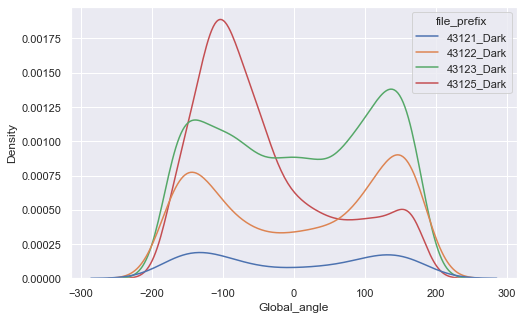

In [45]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,5))
sns.kdeplot(x="Global_angle",hue="file_prefix",hue_order=["43121_Dark","43122_Dark","43123_Dark","43125_Dark"],data=df_Global_Angle_all,ax=ax)
plt.savefig("../results/Global_angle_objects.png",bbox_inches="tight")

## Relative angle

In [61]:
df_relative_Angle_all=pd.DataFrame()

for file_id, df in Moving.groupby("file_prefix"):
    relative_angle=np.hstack(df['RELATIVE_ANGLE'].values)
    df_relative_angle=pd.DataFrame({"Relative_angle":relative_angle})
    df_relative_angle["file_prefix"]=file_id
    df_relative_Angle_all=pd.concat([df_relative_angle,df_relative_Angle_all])
    
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,5))
sns.kdeplot(x="Relative_angle",hue="file_prefix",hue_order=["43121_Dark","43122_Dark","43123_Dark","43125_Dark"],data=df_Relative_Angle_all,ax=ax)
plt.savefig("../results/Relative_angle_objects.png",bbox_inches="tight")

KeyError: 'RELATIVE_ANGLE'

## Sample trajectories

## Translational exponent

In [37]:
"""
Created on Mon Oct 28 09:58:23 2019

@author: pichugina
"""
from sklearn.linear_model import LinearRegression


def traj_translational_exponent(Traj):
    """
    calculate translational exponent and diffusion coefficient
    input: coordinats of the trajectory, 
           dx physical units to recalculate px to mkm 
    output: translational exponent,Diffusion mkm^2/s
    """
    #pixel size mkm
    dx=1.42
    #time frame s
    dt=6
    
    Traj=Traj.sort_values('frame')
    X=Traj['x'].values
    Y=Traj['y'].values
    
    # length of trajectory
    n_lag=5
    tlen = Traj.shape[0]
    delt=np.arange(1,n_lag+1)
    MSD = np.zeros(len(delt))

    for td in delt:
        index1=range(td,tlen)
        index2=range(0,tlen-td)
        dv = (X[index1]-X[index2])**2 + (Y[index1]-Y[index2])**2;
        dv = dx*dx*dv;   # convert to physical units
        MSD[td-1] = np.sum(dv)/len(dv);

    delt=delt*dt
    
    Log_delt=np.log(delt).reshape((-1, 1))
  
    if ((MSD>0).all()):
        Log_MSD=np.log(MSD)
        reg=LinearRegression().fit(Log_delt,Log_MSD)
        r_sq = reg.score(Log_delt,Log_MSD)
        Intersept=reg.intercept_
        Slope=reg.coef_[0]
        D=0.25*np.exp(Intersept)
        results=pd.Series([r_sq,Slope,D],index=['r_sq','Slope','D_mkm2/s'])
        y_pred = reg.predict(Log_delt)
    else:
        results=pd.Series([np.nan,np.nan,np.nan],index=['r_sq','Slope','D_mkm2/s'])
    
    return results

In [38]:
Group_Traj=images_dict[file_prefix]["tracks"].groupby('particle')


In [39]:
Results

r_sq     Slope   D_mkm2/s
particle                               
0         0.999320  1.741724   6.818378
2         0.687636  0.281207   0.037694
3         0.820772  0.209975   0.200453
4         0.900186  0.249431   0.066445
7         0.987323  1.031842   6.271629
...            ...       ...        ...
2272      0.989405  1.341730   5.035522
2286      0.064318 -0.166437   0.192093
2296      0.529349  0.407124  60.775526
2298           NaN       NaN        NaN
2304           NaN       NaN        NaN

[409 rows x 3 columns]

## View object

In [120]:
def viz_object(particle,file_prefix):
    
    # 'major_axis_length','minor_axis_length', 'orientation', 'area', 'perimeter', 'eccentricity',
    #'max_intensity','mean_intensity', 'min_intensity', 'compactness', 'circularity','contrast',  'file_name', 'particle'
    
    
    column_name='area'

    ###========================================####
    tracks=images_dict[file_prefix]["tracks"]
    images=images_dict[file_prefix]["img"]
    binary=images_dict[file_prefix]["binary"]
    traj=tracks[tracks["particle"]==particle]

    delta=10
    min_row,min_col=np.min(traj.loc[:,'bbox-0':'bbox-1'])
    max_row,max_col=np.max(traj.loc[:,'bbox-2':'bbox-3'])

    start_frame=np.min(traj.loc[:,'frame'])
    end_frame=np.max(traj.loc[:,'frame'])

    min_row=np.max([min_row-delta,0])
    min_col=np.max([min_col-delta,0])
    max_row=np.min([max_row+delta,images[0].shape[0]])
    max_col=np.min([max_col+delta,images[0].shape[1]])
               
    traj_img=images[:,min_row:max_row,min_col:max_col]
    traj_seg=binary[:,min_row:max_row,min_col:max_col]


    ###========================================####
    def plot_plane(frame):
        fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
        # particle image
        ax[0].imshow(traj_img[frame],cmap='gray')
        ax[0].axis("off")
    
        # particle image
        ax[1].imshow(traj_seg[frame],cmap='gray')
        ax[1].axis("off")
        
        # area vs frame plot
        ax[2].plot(traj.frame,traj[column_name],'-o')
        ax[2].axvline(x=frame,color='red')
        ax[2].set_title(particle)
        ax[2].set_xlabel("frame")
        ax[2].set_ylabel(column_name)
    plt.show()

    intSlider=widgets.IntSlider(min=start_frame,max=end_frame,step=1,value=0)    
    play_w=widgets.Play(value=0,min=start_frame,max=end_frame,interval=200,description="Press play",disabled=False)
    widgets.jslink((play_w, 'value'), (intSlider, 'value'))
    int_w=widgets.interactive(plot_plane,frame = intSlider)
    container=widgets.VBox([play_w,int_w])

    display(container)

In [1]:
file_prefix="43125_Dark"
TD=TrajDescriptors_all[(TrajDescriptors_all['file_prefix']==file_prefix) & (TrajDescriptors_all['type']=='fixed')]

NameError: name 'TrajDescriptors_all' is not defined

In [129]:
TrajDescriptors_all.columns

Index(['TOTAL_DIST', 'END_TO_END', 'PERSISTENCE', 'MSD', 'MAX_DIST_ORIG',
       'TRAJ_LEN', 'MAX_AREA', 'MEDIAN_MAJOR_AXIS', 'file_prefix', 'RATIO',
       'type'],
      dtype='object')

In [130]:
for particle in TD.index[:15]:
    viz_object(particle,file_prefix)

### Overlapped area

In [7]:
def object_anchor_area(traj,binary_images,ax):
    """ calculate overlapped area i.e sum of pixels that are stay the same across time """
    
    min_row,min_col=np.min(traj.loc[:,'bbox-0':'bbox-1'])
    max_row,max_col=np.max(traj.loc[:,'bbox-2':'bbox-3'])
    
    time_start=np.min(traj.frame)
    time_end=np.max(traj.frame)
    binary_img_region=binary_images[time_start:time_end,min_row:max_row,min_col:max_col]
    
    # calculate anchor mask
    anchor_points=np.zeros_like(binary_img_region[0],dtype=np.int32)
    anchor_points=np.sum(binary_img_region,axis=0)
    anchor_mask=anchor_points>=(255*(binary_img_region.shape[0]))
    ax.imshow(anchor_points,vmin=255,vmax=np.max(anchor_points),cmap='plasma')
    
    ax.axis("off")
    
    # overlap
    sum_overlap_px=np.sum(anchor_mask)
    if np.sum(anchor_mask)>0:
        ax.set_title("file_id={} \n particle_id={} \n anchored=True \n overlapped_area={:.2f}".format(traj["file_name"].iloc[0],traj["particle"].iloc[0],sum_overlap_px/np.mean(traj.area)))
    else:
        ax.set_title("{} \n anchored=False".format(traj["particle"].iloc[0]))
    #print(traj.particle.iloc[0],np.mean(traj.area),sum_overlap_px)
    
    result={'particle':traj.particle.iloc[0],
            'mean_area':np.mean(traj.area),
            'overlapped_area':sum_overlap_px,
            'overlapped_area_ratio':sum_overlap_px/np.mean(traj.area),
            'traj_len':traj.shape[0]}
    
    return result 

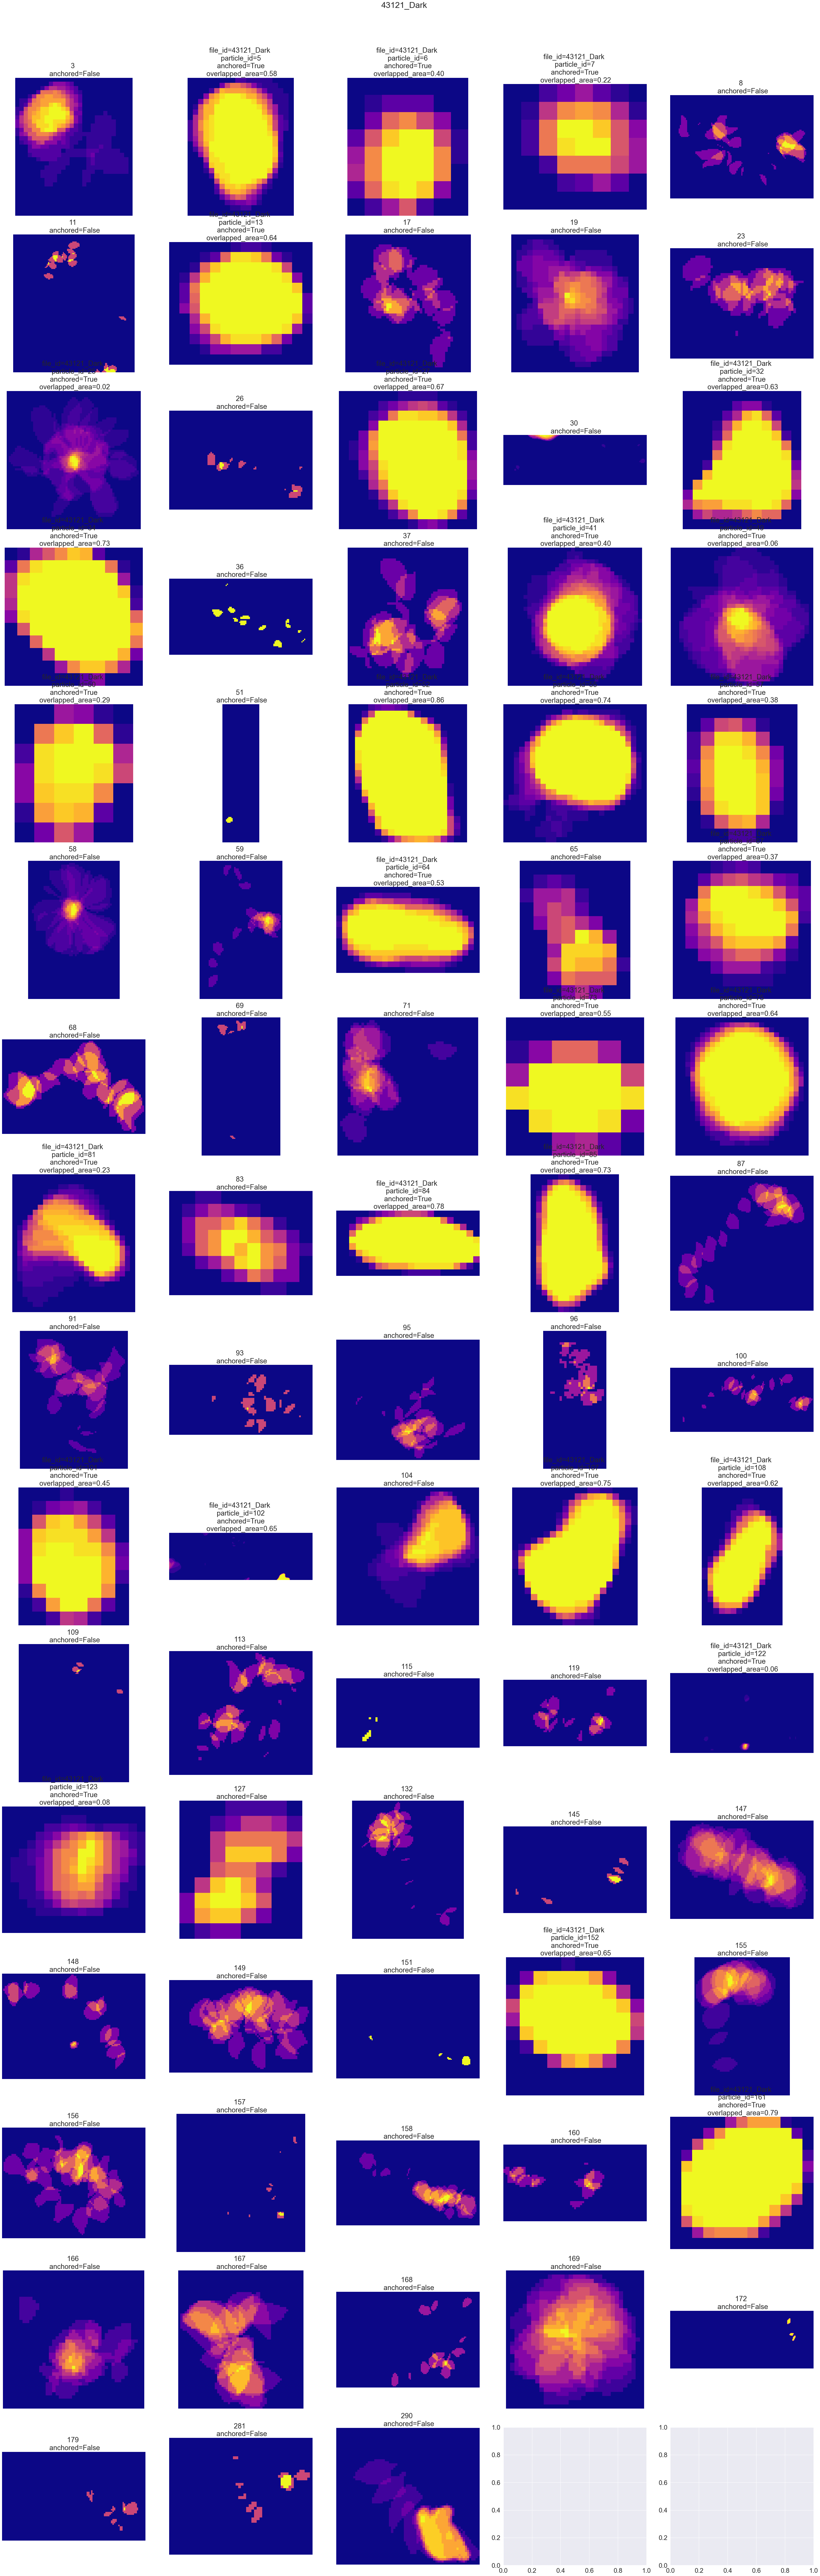

In [8]:
Tracks_len=5
sns.set(font_scale=2)
Anchor_all=pd.DataFrame()

for file_prefix in [file_prefix]:
    tracks=images_dict[file_prefix]["tracks"]
    binary_images=images_dict[file_prefix]["binary"]
    
    # set figure 
    Ngroups=TrajDescriptors.shape[0]
    Nrows=np.int(np.ceil(Ngroups/5))
    fig,ax=plt.subplots(nrows=Nrows,ncols=5,figsize=(40,Nrows*7.5))
    suptitle = plt.suptitle(file_prefix, y=1.02)
    plt.tight_layout()
    axx=ax.ravel()
    
    counter=0
    Anchor_data=[]
    for particle_id in TrajDescriptors.index:
        traj=tracks[tracks['particle']==particle_id]
        result=object_anchor_area(traj,binary_images,axx[counter])
        counter=counter+1
        Anchor_data.append(result)

    Anchor_df=pd.DataFrame(Anchor_data)
    Anchor_df["type"]="fixed"
    Anchor_df["type"][Anchor_df["overlapped_area_ratio"]<=0.50]="rotating"
    Anchor_df["type"][Anchor_df["overlapped_area_ratio"]==0]="moving"
    Anchor_df['file_prefix']=file_prefix
    Anchor_df.to_csv("../results/Anchor_area_small_objects{}.csv".format(file_prefix))
    #plt.savefig("../results/Projection_plot_{}.png".format(file_prefix), bbox_extra_artists=(suptitle,), bbox_inches="tight")
    
    
    Anchor_all=pd.concat([Anchor_df,Anchor_all])

